In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")

from global_config import config
import seaborn as sns

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_db_dir           = config.get_property('data_db_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [3]:
sys.path.insert(0, "../metapop")

from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


In [4]:
wards_use_correct_df = pd.read_csv(os.path.join(results2_dir, "paper_figures", "wards_use_corrected.csv"))

counts_ward_df = pd.read_csv(path_to_ward_counts, parse_dates=["date"])
counts_ward_df = counts_ward_df[counts_ward_df.ward.isin(list(wards_use_correct_df["ward"]))]

In [5]:
from building2title import selected_buildings, building2title

building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id[5]     = "Rest"

def building2building(building):
    if building in selected_buildings:
        return building
    else:
        return "Rest"

counts_ward_df["building"] = counts_ward_df.apply(lambda x: x.ward.split("-")[1], axis=1)
counts_ward_df["building"] = counts_ward_df.apply(lambda x: building2building(x.building), axis=1)

counts_ward_df             = counts_ward_df.reset_index(drop=True)
buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()

date_start    = pd.to_datetime('2020-02-01')
date_end      = pd.to_datetime('2021-02-28')
dates         = pd.date_range(date_start, date_end)
Tdat          =  len(dates)

buildings_df  = buildings_df[buildings_df.date.isin(dates)]

A     = pd.pivot(buildings_df, index='building', columns='date', values='num_admitted')
D     = pd.pivot(buildings_df, index='building', columns='date', values='num_discharged')
H     = pd.pivot(buildings_df, index='building', columns='date', values='num_hospitalized')
tests = pd.pivot(buildings_df, index='building', columns='date', values='num_tested')

pop            = H.mean(axis=1)
num_pop        = len(pop)
building_names = pop.index


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/3443236566.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()


In [6]:
buildings_df["building2"] = buildings_df.apply(lambda x: building2building(x.building), axis=1)
buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/2098979460.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/2098979460.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/1117662797.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_df   = buildings_plt_df.groupby(['date']).sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/1117662797.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_w_df = buildings_plt_df.groupby(['date']).sum().resample("W-Sun").sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/1117662797.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

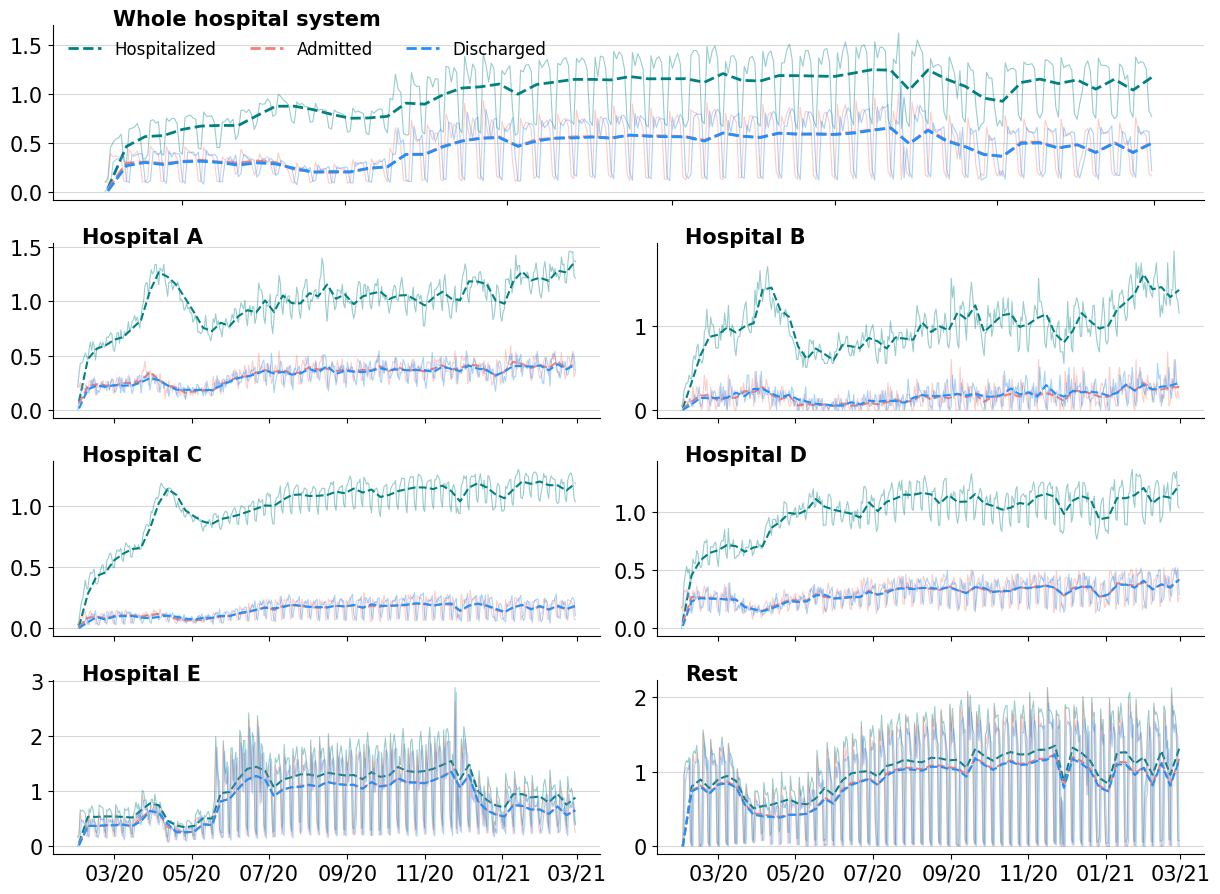

In [7]:
from matplotlib import dates as mdates
from utils_local import plot_utils
import matplotlib.pyplot as plt

H_ward_df     = pd.pivot(counts_ward_df,
                                index='ward', columns='date', values='num_hospitalized')

pop_ward                = np.clip(np.ceil(H_ward_df.mean(axis=1)), 1, None)
pop_ward_df             = pd.DataFrame(pop_ward, columns=["ward_size"]).reset_index()
pop_ward_df["building"] = pop_ward_df["ward"].apply(lambda x: x.split("-")[1])

layout = [["hospital", "hospital"],
          [selected_buildings[0],   selected_buildings[1]],
            [selected_buildings[2], selected_buildings[3]],
            [selected_buildings[4], selected_buildings[5]]]

fig, axes = plt.subplot_mosaic(layout,
                                figsize=(12.5, 9.2),
                                sharex=True, sharey=False)

hosp_df   = buildings_plt_df.groupby(['date']).sum().reset_index()
hosp_w_df = buildings_plt_df.groupby(['date']).sum().resample("W-Sun").sum().reset_index()

axes["hospital"].plot(hosp_df["date"],   hosp_df.num_hospitalized   / pop.sum(),     lw=0.8, alpha=0.4, color="teal")
axes["hospital"].plot(hosp_w_df["date"], hosp_w_df.num_hospitalized / (7*pop.sum()), lw=2, color="teal", ls="--", label="Hospitalized")

axes["hospital"].plot(hosp_df["date"],   hosp_df.num_admitted   /  pop.sum(),    lw=0.8, alpha=0.4, color="salmon")
axes["hospital"].plot(hosp_w_df["date"], hosp_w_df.num_admitted / (7*pop.sum()), lw=2, color="salmon", ls="--", label="Admitted")

axes["hospital"].plot(hosp_df["date"],   hosp_df.num_discharged  / pop.sum(),      lw=0.8, alpha=0.4, color="dodgerblue")
axes["hospital"].plot(hosp_w_df["date"], hosp_w_df.num_discharged/ (7* pop.sum()), lw=2, color="dodgerblue", ls="--", label="Discharged")

axes["hospital"].legend(loc="upper left", ncol=3, fontsize=12, frameon=False)
axes["hospital"].spines['right'].set_visible(False)
axes["hospital"].spines['top'].set_visible(False)
axes["hospital"].set_ylabel(None)
axes["hospital"].set_xlabel(None)

axes["hospital"].text(x         = 18296.0,
                    y          = axes["hospital"].get_ylim()[1],
                    s          = "Whole hospital system",
                    fontweight = "bold")

axes["hospital"].grid(which="major", axis="y", color="gray", alpha=0.3)


for idx_k, building in enumerate(selected_buildings):

    counts_ward_b_day_df = counts_ward_df[counts_ward_df.building == building]
    counts_ward_b_day_df.loc[:, "num_hospitalized_norm"] = counts_ward_b_day_df.apply(lambda x: x.num_hospitalized / pop_ward[x.ward], axis=1)
    counts_ward_b_day_df.loc[:, "num_discharged_norm"]   = counts_ward_b_day_df.apply(lambda x: x.num_discharged   / pop_ward[x.ward], axis=1)
    counts_ward_b_day_df.loc[:, "num_admitted_norm"]     = counts_ward_b_day_df.apply(lambda x: x.num_admitted     / pop_ward[x.ward], axis=1)

    counts_ward_b_wk_df                                 = counts_ward_b_day_df.set_index(["date", "ward"]).unstack([1])[["num_hospitalized", "num_admitted", "num_discharged"]].resample("W-Sun").sum().stack().reset_index()
    counts_ward_b_wk_df.loc[:, "num_hospitalized_norm"] = counts_ward_b_wk_df.apply(lambda x: x.num_hospitalized   / (7*pop_ward[x.ward]), axis=1)
    counts_ward_b_wk_df.loc[:, "num_discharged_norm"]   = counts_ward_b_wk_df.apply(lambda x: x.num_discharged / (7*pop_ward[x.ward]), axis=1)
    counts_ward_b_wk_df.loc[:, "num_admitted_norm"]     = counts_ward_b_wk_df.apply(lambda x: x.num_admitted   / (7*pop_ward[x.ward]), axis=1)

    b_df     = counts_ward_b_day_df.groupby(["date"])[["num_hospitalized", "num_admitted", "num_discharged"]].sum().reset_index()
    b_w_df   = counts_ward_b_day_df.groupby(["date"])[["num_hospitalized", "num_admitted", "num_discharged"]].sum().resample("W-Sun").sum().reset_index()

    pop_b_df = pop_ward_df[pop_ward_df.building == building]

    axes[building].plot(b_df["date"],   b_df.num_hospitalized   / pop[building],     lw=0.8, alpha=0.4, color="teal")
    axes[building].plot(b_w_df["date"], b_w_df.num_hospitalized / (7*pop[building]), lw=1.5, color="teal", ls="--", label="Hospitalized")

    axes[building].plot(b_df["date"],   b_df.num_admitted   /  pop[building],    lw=0.8, alpha=0.4, color="salmon")
    axes[building].plot(b_w_df["date"], b_w_df.num_admitted / (7*pop[building]), lw=1.5, color="salmon", ls="--", label="Admitted")

    axes[building].plot(b_df["date"],   b_df.num_discharged  / pop[building],      lw=0.8, alpha=0.4, color="dodgerblue")
    axes[building].plot(b_w_df["date"], b_w_df.num_discharged/ (7* pop[building]), lw=1.5, color="dodgerblue", ls="--", label="Discharged")

    axes[building].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axes[building].tick_params(which='both', axis='x', labelrotation=0)

    if idx_k in [len(selected_buildings)-2, len(selected_buildings)-1]:
        axes[building].tick_params('x', labelbottom=True)

    axes[building].legend().remove()
    axes[building].text(x         = 18296.0,
                        y          = axes[building].get_ylim()[1],
                        s          = building2title[building],
                        fontweight = "bold")

    axes[building].spines['right'].set_visible(False)
    axes[building].spines['top'].set_visible(False)
    axes[building].set_ylabel(None)
    axes[building].set_xlabel(None)
    axes[building].grid(which="major", axis="y", color="gray", alpha=0.3)

plt.tight_layout()

#fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures_corrected", "WardSizeDistribution_figS2.png"),
#                                                                                        dpi         = 300,
#                                                                                        transparent = True,
#                                                                                        bbox_inches = 'tight')
fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures_corrected", "HospitalTraffic_BuildingLevel_figS3.png"),
                                                                                                            dpi         = 300,
                                                                                                            transparent = True,
                                                                                                            bbox_inches = 'tight')

In [8]:
adm_hosp = hosp_df.num_admitted
print("Hospital level admissions: {:.2f}, {:.2f}".format(np.round(adm_hosp[30:].min()), np.round(adm_hosp[30:].max())))


d_rate_hosp = hosp_df.num_discharged / ( pop.sum() )
print("Hospital level admission rate: {:.2f}, {:.2f}".format(np.round(d_rate_hosp[4:].min() * 100), np.round(d_rate_hosp[30:].max() * 100)))

Hospital level admissions: 149.00, 1745.00
Hospital level admission rate: 7.00, 109.00


In [9]:
adm_rate_hosp = hosp_df.num_admitted / (pop.sum() )
print("Hospital level admission rate: {:.2f}, {:.2f}".format(np.round(adm_rate_hosp[4*7:].min() * 100), np.round(adm_rate_hosp[30:].max() * 100)))


d_rate_hosp = hosp_df.num_discharged / ( pop.sum() )
print("Hospital level admission rate: {:.2f}, {:.2f}".format(np.round(d_rate_hosp[4:].min() * 100), np.round(d_rate_hosp[30:].max() * 100)))

Hospital level admission rate: 9.00, 101.00
Hospital level admission rate: 7.00, 109.00


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/2393021153.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  A_ward_df     = pd.pivot(counts_ward_df.set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index(),
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/2393021153.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  D_ward_df     = pd.pivot(counts_ward_df.set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index(),
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/2393021153.py:23: SettingWithCopyWarning: 

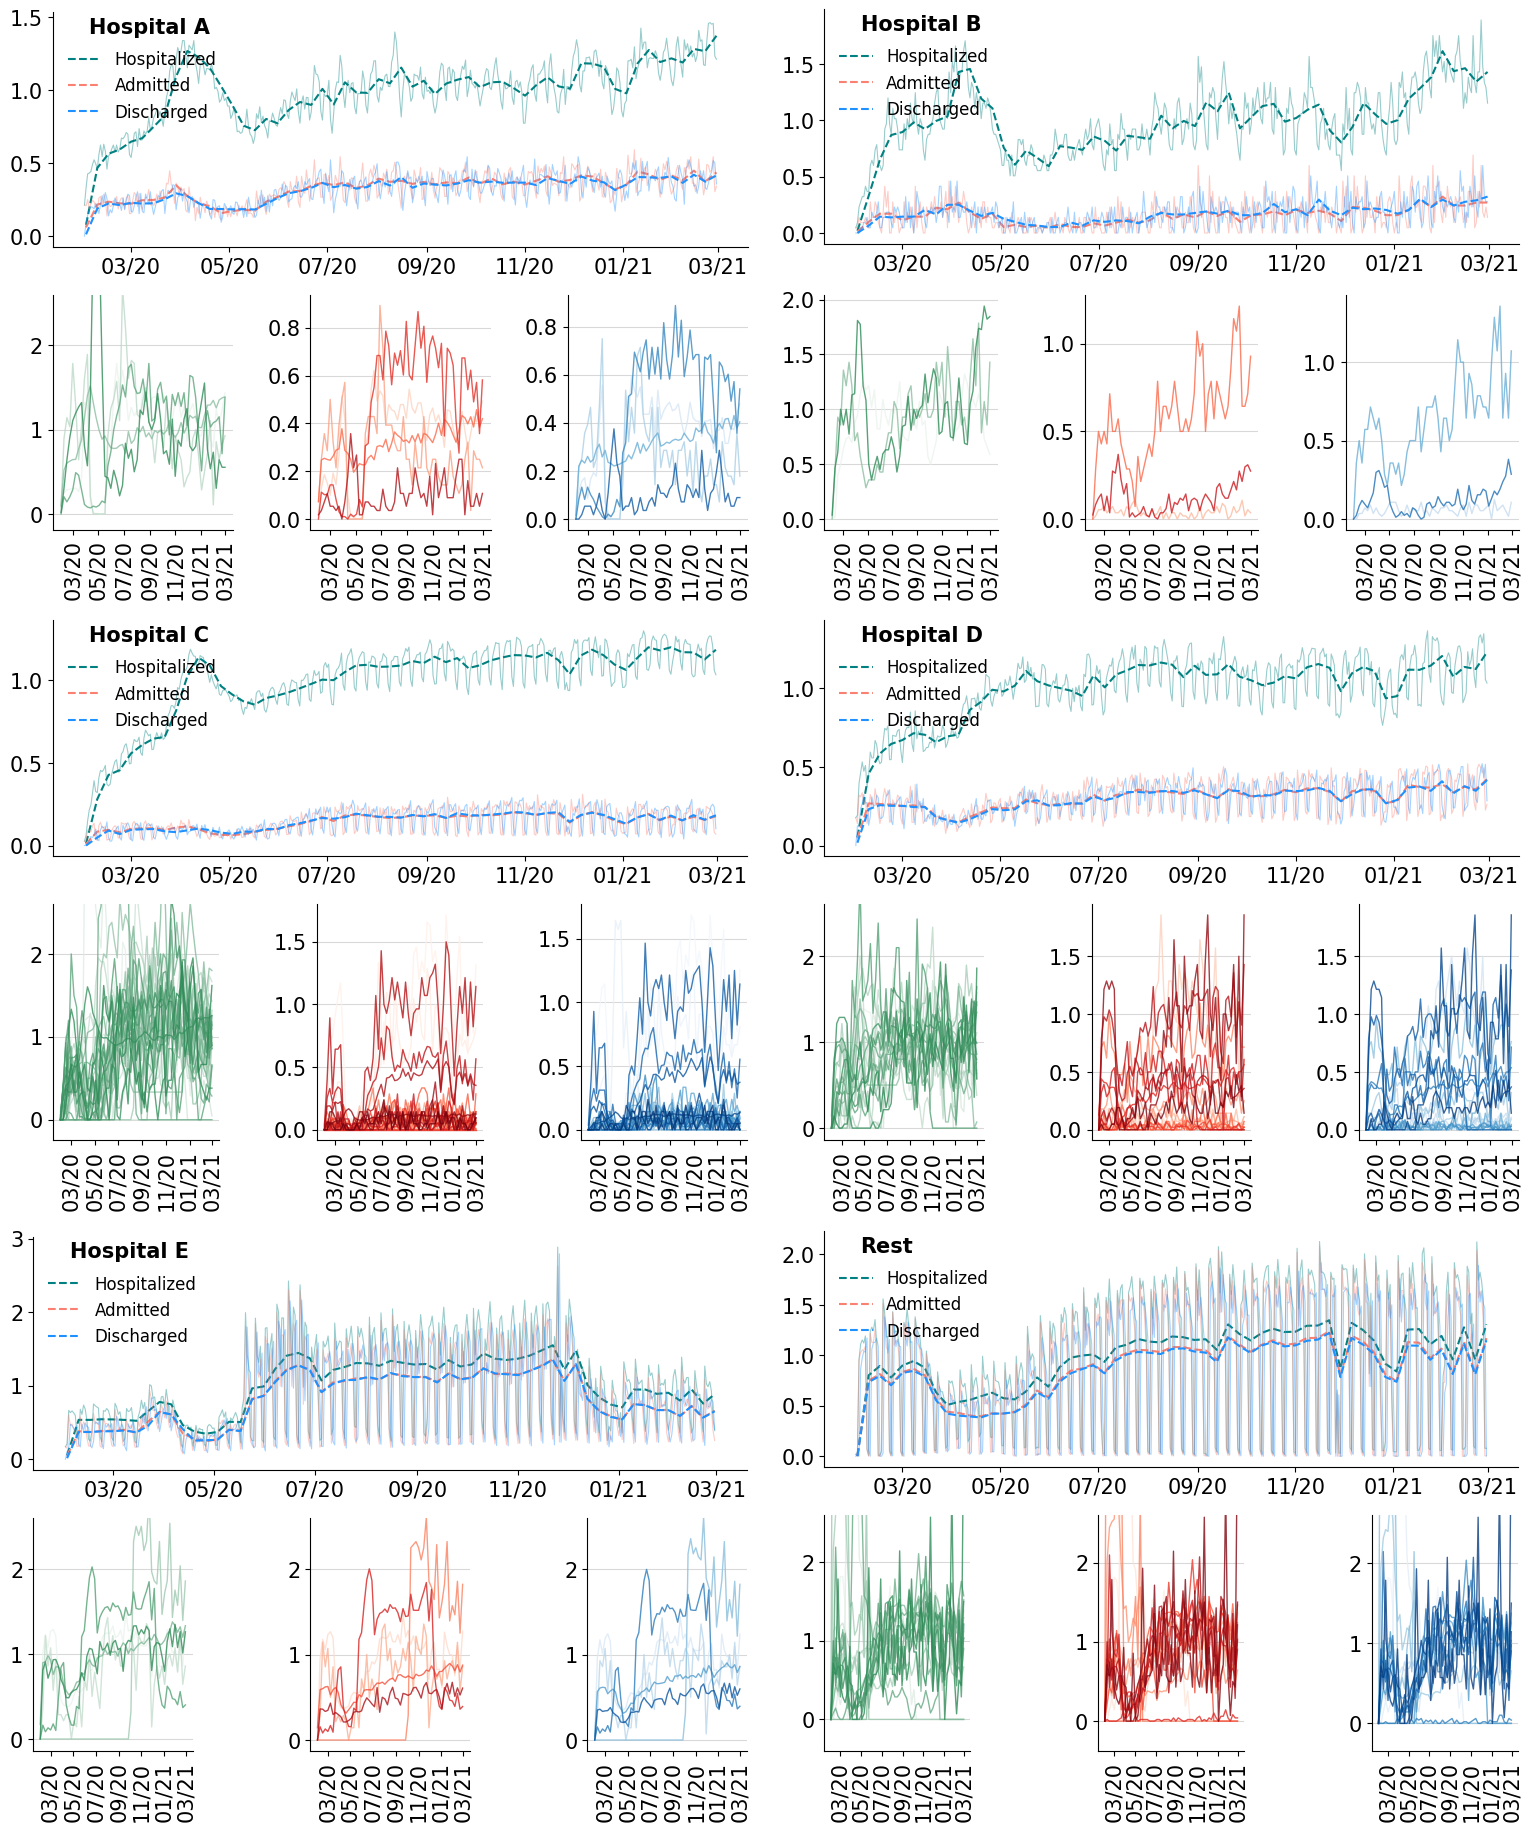

In [10]:
A_ward_df     = pd.pivot(counts_ward_df.set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index(),
                                index='ward', columns='date', values='num_admitted')
D_ward_df     = pd.pivot(counts_ward_df.set_index(["date", "ward"]).unstack([1]).resample("W-Sun").sum().stack().reset_index(),
                                index='ward', columns='date', values='num_admitted')
H_ward_df     = pd.pivot(counts_ward_df,
                                index='ward', columns='date', values='num_hospitalized')

pop_ward                = np.clip(np.ceil(H_ward_df.mean(axis=1)), 1, None)
pop_ward_df             = pd.DataFrame(pop_ward, columns=["ward_size"]).reset_index()
pop_ward_df["building"] = pop_ward_df["ward"].apply(lambda x: x.split("-")[1])
pop_ward_df["building"] = pop_ward_df["building"].map(lambda x: building2building(x))



fig     = plt.figure(constrained_layout=True, figsize=(15.2, 18.2))

subfigs = fig.subfigures(len(selected_buildings)//2, 2, hspace=0.02, wspace=0.03, height_ratios=[1/3]*(len(selected_buildings)//2), width_ratios=[0.5, 0.5])
subfigs = subfigs.flatten()

for idx_building, building in enumerate(selected_buildings):
    counts_ward_b_day_df = counts_ward_df[counts_ward_df.building == building]

    counts_ward_b_day_df["num_hospitalized_norm"] = counts_ward_b_day_df.apply(lambda x: x.num_hospitalized / pop_ward[x.ward], axis=1)
    counts_ward_b_day_df["num_discharged_norm"]   = counts_ward_b_day_df.apply(lambda x: x.num_discharged   / pop_ward[x.ward], axis=1)
    counts_ward_b_day_df["num_admitted_norm"]     = counts_ward_b_day_df.apply(lambda x: x.num_admitted     / pop_ward[x.ward], axis=1)

    counts_ward_b_wk_df                                 = counts_ward_b_day_df.set_index(["date", "ward"]).unstack([1])[["num_hospitalized", "num_admitted", "num_discharged"]].resample("W-Sun").sum().stack().reset_index()
    counts_ward_b_wk_df.loc[:, "num_hospitalized_norm"] = counts_ward_b_wk_df.apply(lambda x: x.num_hospitalized   / (7*pop_ward[x.ward]), axis=1)
    counts_ward_b_wk_df.loc[:, "num_discharged_norm"]   = counts_ward_b_wk_df.apply(lambda x: x.num_discharged / (7*pop_ward[x.ward]), axis=1)
    counts_ward_b_wk_df.loc[:, "num_admitted_norm"]     = counts_ward_b_wk_df.apply(lambda x: x.num_admitted   / (7*pop_ward[x.ward]), axis=1)

    b_df     = counts_ward_b_day_df.groupby(["date"])[["num_hospitalized", "num_admitted", "num_discharged"]].sum().reset_index()
    b_w_df   = counts_ward_b_day_df.groupby(["date"])[["num_hospitalized", "num_admitted", "num_discharged"]].sum().resample("W-Sun").sum().reset_index()

    pop_b_df = pop_ward_df[pop_ward_df.building == building]

    axes = subfigs[idx_building].subplot_mosaic([["building", "building", "building"],
                                                ["hospitalizations", "admissions", "discharges"]],
                                                sharex=False, sharey=False)

    axes["building"].plot(b_df["date"],   b_df.num_hospitalized   / pop[building],     lw=0.8, alpha=0.4, color="teal")
    axes["building"].plot(b_w_df["date"], b_w_df.num_hospitalized / (7*pop[building]), lw=1.5, color="teal", ls="--", label="Hospitalized")

    axes["building"].plot(b_df["date"],   b_df.num_admitted   /  pop[building],    lw=0.8, alpha=0.4, color="salmon")
    axes["building"].plot(b_w_df["date"], b_w_df.num_admitted / (7*pop[building]), lw=1.5, color="salmon", ls="--", label="Admitted")

    axes["building"].plot(b_df["date"],   b_df.num_discharged  / pop[building],      lw=0.8, alpha=0.4, color="dodgerblue")
    axes["building"].plot(b_w_df["date"], b_w_df.num_discharged/ (7* pop[building]), lw=1.5, color="dodgerblue", ls="--", label="Discharged")

    big_wards     =  pop_b_df[pop_b_df.ward_size >=  2]["ward"]
    palette_hosp  = sns.light_palette("seagreen", n_colors=len(big_wards))
    palette_adms  = sns.color_palette("Reds",     n_colors=len(big_wards), desat=True)
    palette_disch = sns.color_palette("Blues",    n_colors=len(big_wards), desat=True)

    sns.lineplot(ax=axes["hospitalizations"], data=counts_ward_b_wk_df[counts_ward_b_wk_df.ward.isin(list(big_wards))],
                                                x="date", y="num_hospitalized_norm",  lw=1, alpha=0.8, hue="ward", palette=palette_hosp)
    sns.lineplot(ax=axes["admissions"],       data=counts_ward_b_wk_df[counts_ward_b_wk_df.ward.isin(list(big_wards))],
                                                x="date", y="num_admitted_norm",      lw=1, alpha=0.8, hue="ward", palette=palette_adms)
    sns.lineplot(ax=axes["discharges"],       data=counts_ward_b_wk_df[counts_ward_b_wk_df.ward.isin(list(big_wards))],
                                                x="date", y="num_discharged_norm",    lw=1, alpha=0.8, hue="ward", palette=palette_disch)

    axes["building"].text(x        = 18296.0,
                        y          = axes["building"].get_ylim()[1]+axes["building"].get_ylim()[0] * 2,
                        s          = building2title[building],
                        fontweight = "bold")

    axes["building"].legend(loc            = "upper left",
                            bbox_to_anchor = (0.0, 0.9),
                            ncol           = 1,
                            fontsize       = 12,
                            frameon        = False)

    for k in axes:
        axes[k].spines['right'].set_visible(False)
        axes[k].spines['top'].set_visible(False)
        axes[k].set_ylabel(None)
        axes[k].set_xlabel(None)

        if k == "ward_size":
            #axes[k].set_xlabel("ward size")
            continue

        axes[k].tick_params(which='both', axis='x', labelrotation=90)
        axes[k].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

        if k == "building":
            axes[k].tick_params(which='both', axis='x', labelrotation=0)
            continue

        axes[k].legend().remove()
        axes[k].set_ylim((axes[k].get_ylim()[0], np.minimum(2.6, axes[k].get_ylim()[1])))
        axes[k].grid(which="major", axis="y", color="gray", alpha=0.3)

    subfigs[idx_building].subplots_adjust(wspace=0.01, hspace=0.02)

fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures_corrected", "HospitalTraffic_WardLevel_figS4.png"),
                                                                                        dpi         = 300,
                                                                                        transparent = True,
                                                                                        bbox_inches = 'tight')


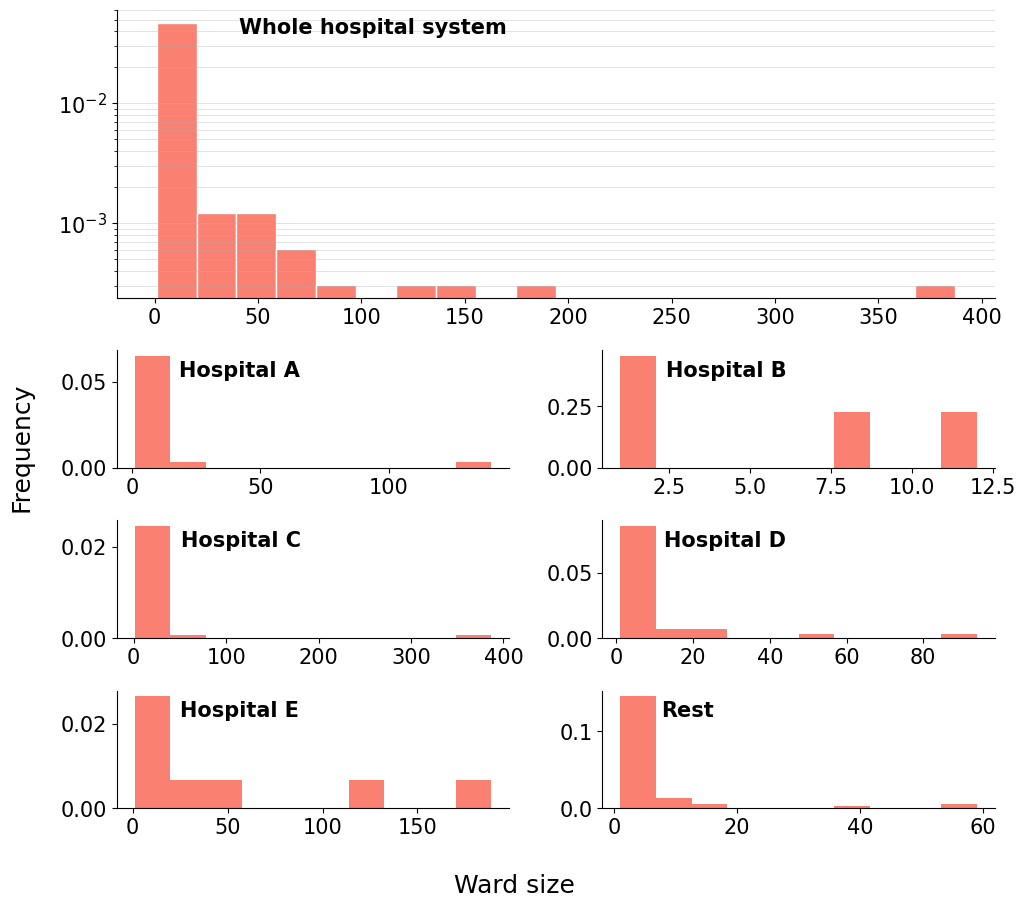

In [11]:
from scipy.stats import powerlaw
from scipy.stats import expon


layout = [["hospital", "hospital"],
          ["hospital", "hospital"],
          [selected_buildings[0], selected_buildings[1]],
          [selected_buildings[2], selected_buildings[3]],
          [selected_buildings[4], selected_buildings[5]]]

fig, axes = plt.subplot_mosaic(layout,
                                figsize=(10.5, 9.2),
                                sharex=False, sharey=False)

ax = axes["hospital"]

ax.hist(pop_ward_df[pop_ward_df.ward_size >= 1].ward_size.values,
                bins=20, edgecolor="w", facecolor="salmon", density=True, align="mid")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.grid(which="both", axis="y", lw=0.5, alpha=0.5)
ax.text(x              = ax.get_xlim()[1] / 10,
            y          = ax.get_ylim()[1] - ax.get_ylim()[1]/4.5,
            s          = "Whole hospital system",
            fontweight = "bold")

ax.set_yscale("log")

for building in selected_buildings:

    axi         = axes[building]
    ward_sizes  = pop_ward_df[pop_ward_df.building==building].ward_size.values
    x           = np.arange(1, ward_sizes.max()+1)
    count, bins = np.histogram(ward_sizes, bins = x, range = (ward_sizes.min(), ward_sizes.max()+1))

    axi.hist(pop_ward_df.query(f"building=='{building}' and ward_size>0").ward_size.values,
             facecolor="salmon", density=True, align="mid")

    if building == "Harkness Pavilion":
        xpos = 2.4
    else:
        xpos = axi.get_xlim()[1] / 8

    axi.text(x             = xpos,
                y          = axi.get_ylim()[1] - axi.get_ylim()[1]/4.5,
                s          = building2title[building],
                fontweight = "bold")

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

fig.supxlabel(r'Ward size')
fig.supylabel(r'Frequency')
plt.tight_layout()

fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures_corrected", "WardSizeDistribution_figS2.png"),
                                                                                        dpi         = 300,
                                                                                        transparent = True,
                                                                                        bbox_inches = 'tight')

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8230/979640181.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(ticksss)


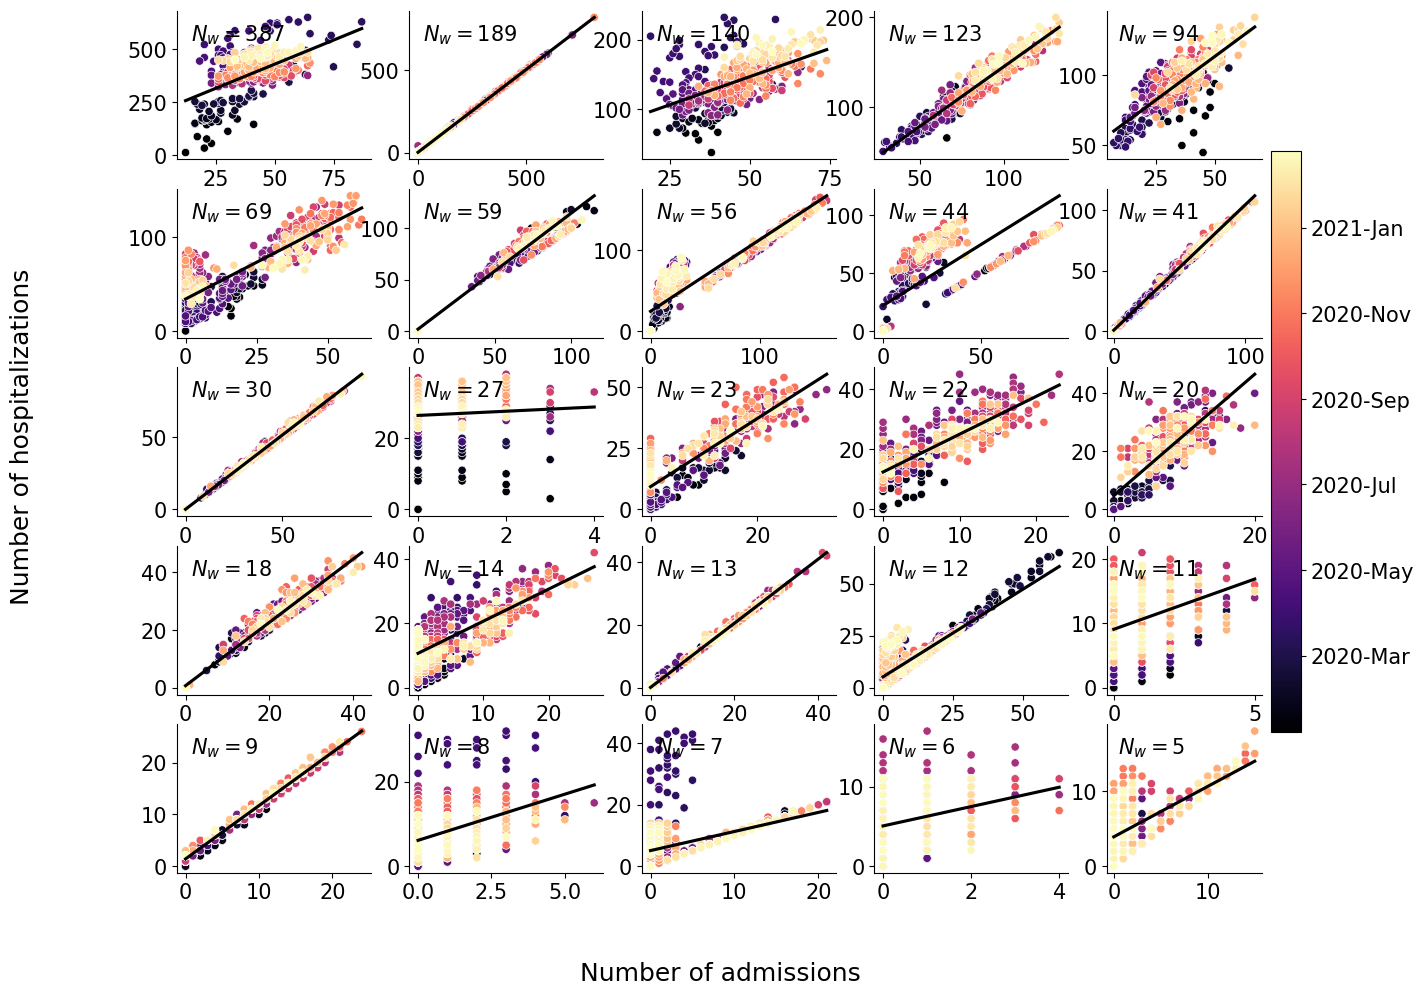

In [12]:
import seaborn as sns

ward2size                   = {w: ws for w, ws in zip(pop_ward_df.ward, pop_ward_df.ward_size)}
counts_ward_df["ward_size"] = counts_ward_df["ward"].map(ward2size)
counts_ward_df["date_num"]  = counts_ward_df["date"].dt.strftime("%Y%m%d").astype(int)
top_10_big                  = np.flip(np.sort(counts_ward_df.ward_size.unique()))

fig, axes = plt.subplots(5, 5, figsize=(14.5, 11.2))
PALETTE   = "magma"

for idx_ward, ax in enumerate(axes.flatten()):

    sns.scatterplot(ax=ax, data=counts_ward_df[counts_ward_df.ward_size==top_10_big[idx_ward]],
                            x ="num_admitted", y="num_hospitalized", hue="date", palette=PALETTE, sizes=(10, 100), edgecolor="w")

    line_slope = sns.regplot(ax=ax, x="num_admitted", y="num_hospitalized", data=counts_ward_df[counts_ward_df.ward_size==top_10_big[idx_ward]],
                                        scatter_kws={"s": 0}, ci=None, color="k")

    xlimsss = ax.get_xlim(); ylimsss = ax.get_ylim()

    ax.text(xlimsss[0]+(xlimsss[1]-xlimsss[0])/14, ylimsss[1]-(ylimsss[1]-ylimsss[0])/5, r"$N_{{w}}=${:.0f}".format(int(top_10_big[idx_ward])))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)

norm = plt.Normalize(min(counts_ward_df.date.unique()), max(counts_ward_df.date.unique()))
sm   = plt.cm.ScalarMappable(cmap=PALETTE, norm=norm)
sm.set_array([])

cb      = fig.colorbar(sm, ax = axes[:,-1])
ticksss = [t.strftime("%Y-%b") for t in pd.to_datetime(cb.get_ticks())]
cb.set_ticklabels(ticksss)

fig.supxlabel(r'Number of admissions', y=0.01)
fig.supylabel(r'Number of hospitalizations', x=0.01)

fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures_corrected", "HospitalizationvsAdmissions_FigS5.png"),
                                                                                        dpi         = 300,
                                                                                        transparent = True,
                                                                                        bbox_inches = 'tight')



In [13]:
def lin_reg(x, y):
    y    = np.expand_dims(y, -1)
    xreg = np.float64(np.concatenate([np.expand_dims(x, -1), np.ones_like(y)], axis=1))
    p    = np.linalg.pinv(xreg.T @ xreg) @ xreg.T @ y
    x    = np.expand_dims(np.linspace(np.around(np.min(x),1), np.max(x), 100), -1)
    x    = np.float64(np.concatenate([x, np.ones_like(x)], axis=1)).T
    yhat = np.squeeze(p.T @ x)
    return x[0,:], yhat, p


In [14]:
p_lr_df = pd.DataFrame()
for building in selected_buildings:

    counts_ward_building_df = counts_ward_df[counts_ward_df.building==building]
    wards_build_df          = counts_ward_building_df[counts_ward_building_df.ward_size>1][["ward", "ward_size"]].drop_duplicates()
    lr_df                   = counts_ward_building_df[counts_ward_building_df.ward_size>1][["ward", "num_admitted", "num_hospitalized"]]

    for _, row_ward in wards_build_df.iterrows():

        x = np.squeeze(lr_df[lr_df.ward==row_ward.ward].num_admitted.values)
        y = np.squeeze(lr_df[lr_df.ward==row_ward.ward].num_hospitalized.values)

        _, _, p = lin_reg(x, y)

        p_lr_df = pd.concat([p_lr_df, pd.DataFrame.from_dict({"building":    building,
                                                                "ward":      row_ward.ward,
                                                                "slope":     p[0, 0],
                                                                "intercept": p[1, 0],
                                                                "ward_size": row_ward.ward_size},
                                                                orient="index").T
                                    ], ignore_index=True, axis=0)

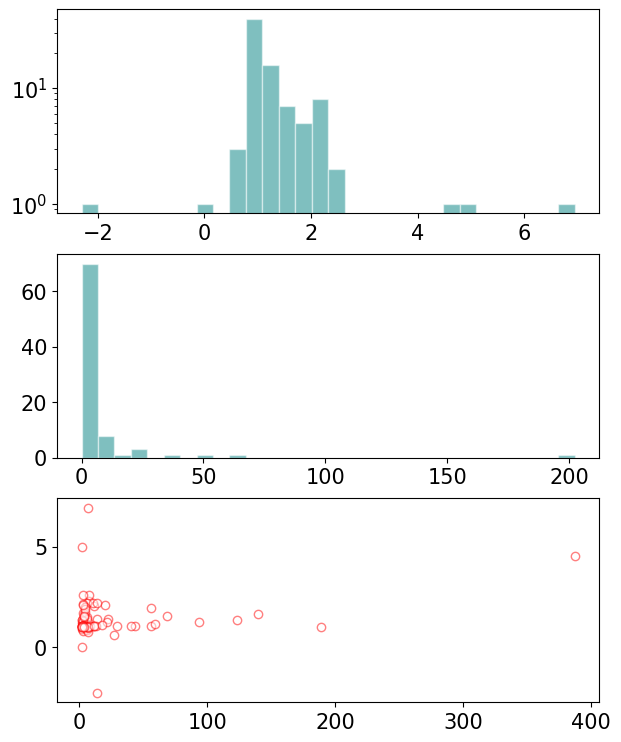

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(7, 9))
ax[0].hist(p_lr_df.slope,    bins  = 30, color="teal", ec="w", alpha=0.5, align="mid")
ax[1].hist(p_lr_df.intercept, bins = 30, color="teal", ec="w", alpha=0.5, align="mid")

ax[2].scatter(p_lr_df[p_lr_df.ward_size<1000].ward_size, p_lr_df[p_lr_df.ward_size<1000].slope, color="red", fc="w", alpha=0.5)
ax[0].set_yscale("log")
